In [1]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/bosonic/bqec@huikhoon')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import utility as ut
import constant as constant

%config InlineBackend.figure_formats = ['svg']

# Two-mode case

In [42]:
dim_a = 15
dim_c = 5

a = qt.tensor(qt.destroy(dim_a), qt.qeye(dim_c))
c = qt.tensor(qt.qeye(dim_a), qt.destroy(dim_c))

n_a = a.dag() * a
n_c = c.dag() * c

## Parameters

In [43]:
omega_10_default = 4.936 # GHz
alpha_default = 0.168 # GHz

## Full Hamiltonian

In [44]:
def time_dependent_Hamiltonian(t, omega_10, alpha, r1, r2, r3, r4, couplingOn, driveOn):

    delta_a = r1 * alpha
    omega_a = omega_10 + delta_a
    omega_c = omega_10 + alpha

    delta_d = r2 * alpha
    omega_d = omega_10 + delta_d

    Omega_d = r3 * delta_d

    g_a = r4 * delta_a 

    H_cav = omega_a * n_a 
    H_anc = omega_c * n_c - alpha * ( c.dag() + c ) **4 / 12
    H_drv = ( c - c.dag() ) * ( np.conj( Omega_d ) * np.exp( 1j * omega_d * t ) - np.exp( -1j * omega_d * t ) * Omega_d )
    H_int = g_a * ( c - c.dag() ) * ( a.dag() + a)

    switchCoupling = 0
    switchDrive = 0

    if couplingOn == True:
        switchCoupling = 1
    if driveOn == True:
        switchDrive = 1

    H_t = H_cav + H_anc + switchCoupling * H_int + switchDrive * H_drv 

    return H_t

In [90]:
def time_independent_Hamiltonian(dim_a, dim_c, omega_10, alpha, r1, r2, r3, r4, couplingOn, driveOn):

    a = qt.tensor(qt.destroy(dim_a), qt.qeye(dim_c))
    c = qt.tensor(qt.qeye(dim_a), qt.destroy(dim_c))

    n_a = a.dag() * a
    n_c = c.dag() * c
    
    delta_a = r1 * alpha
    omega_a = omega_10 + delta_a 
    omega_c = omega_10 + alpha
    
    delta_d = r2 * alpha
    omega_d = omega_10 + delta_d

    delta_da = omega_d - omega_a 
    delta_dc = omega_d - omega_c 
    Omega_d = r3 * delta_d

    g_a = r4 * delta_a 

    H_cav = - delta_da * n_a 
    H_anc = - delta_dc * n_c - ( alpha / 2 ) * ( c.dag() * c + 1 ) * c.dag() * c 
    H_drv = Omega_d * c.dag() + np.conj(Omega_d) * c 
    H_int = g_a * a * c.dag() + np.conj(g_a) * a.dag() * c 

    switchCoupling = 0
    switchDrive = 0

    if couplingOn == True:
        switchCoupling = 1
    if driveOn == True:
        switchDrive = 1

    H_RWA = H_cav + H_anc + switchCoupling * H_int + switchDrive * H_drv 

    return delta_da, H_RWA

# Reproducing PRA 105 (2022) 

In [78]:
_, H_tm_RWA_bare = time_independent_Hamiltonian(omega_10=4.936, alpha=0.168, r1=9.64, r2=0.08, r3=0, r4=0.064, couplingOn=False, driveOn=False)

bare_tm_eig_energies, bare_tm_eig_states = H_tm_RWA_bare.eigenstates()

bare_labelling = []

for idx, state in enumerate(bare_tm_eig_states):
    n_a_val = np.real((state.dag() * n_a * state).full()[0][0])
    n_c_val = np.real((state.dag() * n_c * state).full()[0][0])

    bare_labelling.append((n_a_val, n_c_val))

bare_labelling = np.array(bare_labelling)

# NO DRIVE
delta_da, H_tm_RWA_entangled = time_independent_Hamiltonian(omega_10=4.936, alpha=0.168, r1=9.64, r2=0.08, r3=0, r4=0.064, couplingOn=True, driveOn=False)

entangled_tm_eig_energies, entangled_tm_eig_states = H_tm_RWA_entangled.eigenstates()
entangled_labelling = bare_labelling - bare_labelling 

for i, entangled_state in enumerate(entangled_tm_eig_states):
    
    highest_fidelity_found = 0
    idx_found_by_state_fidelity = 0

    for j, uncoulped_state in enumerate(bare_tm_eig_states):
        
        # Compute state fidelity
        state_fidelity = qt.fidelity(entangled_state, uncoulped_state)
        
        # Update index
        if state_fidelity > highest_fidelity_found:
            highest_fidelity_found = state_fidelity
            idx_found_by_state_fidelity = j
    
    # Acquire entangled labelling index
    entangled_labelling[i] = bare_labelling[idx_found_by_state_fidelity]

cond = entangled_labelling[:, 1] == 0
transmon_ground_state_indices = np.where(cond)[0]
entangled_labelling_filtered = entangled_labelling[transmon_ground_state_indices]

Energies = entangled_tm_eig_energies[transmon_ground_state_indices]
Energies = Energies - Energies[0]
NA = entangled_labelling_filtered[:, 0]

popt, pcov, y_fit = ut.fit_function(
    NA[:-1], Energies[:-1], 
    lambda x, c1, c2, c3, c4: ( ( -delta_da + c1 ) * x + c2 * x**2 + c3 * x**3 + c4 * x**4  ),
    [0, 1e-6, 1e-7, 1e-8]
)

popt

array([ 6.60792081e-03, -1.31413395e-06,  1.47139208e-09, -2.06209299e-11])

### $K_{A,0}^{\Omega_d=0}=-2.639$ kHz

### Check whether the Hamiltonian setup is correct

In [79]:
NA_int = np.array([round(N) for N in NA])

In [80]:
dressed_state_psi0 = entangled_tm_eig_states[transmon_ground_state_indices]

In [82]:
plus_beta_state = 0

beta = np.sqrt(3)

for idx, NA_val in enumerate(NA_int):
    plus_beta_state += ((beta**NA_val) / np.sqrt(np.math.factorial(NA_val))) * dressed_state_psi0[idx]

plus_beta_state = np.exp(-np.abs(beta)**2/2) * plus_beta_state   

minus_beta_state = 0

beta = -np.sqrt(3)

for idx, NA_val in enumerate(NA_int):
    minus_beta_state += ((beta**NA_val)/ np.sqrt(np.math.factorial(NA_val))) * dressed_state_psi0[idx]

minus_beta_state = np.exp( -np.abs(beta)**2 / 2 ) * minus_beta_state    

N = 2 + 2 * np.exp(-2*np.abs(beta)**2)
beta_state = (plus_beta_state + minus_beta_state) * N**(-1/2)

In [84]:
H = (-1j*H_tm_RWA_entangled*100*1e3)
propagator = H.expm()

final_state = propagator * beta_state

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

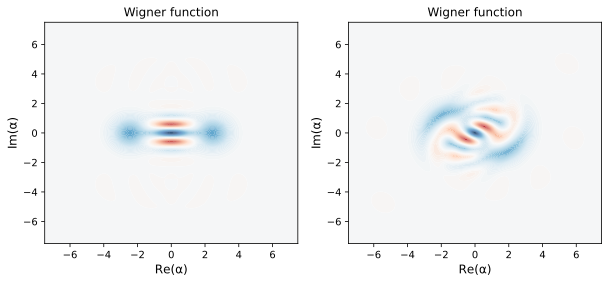

In [89]:
xvec = np.linspace(-6, 6, 200)
yvec = np.linspace(-6, 6, 200)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
qt.plot_wigner(beta_state.ptrace(0), fig=fig, ax=ax1)
qt.plot_wigner(final_state.ptrace(0), fig=fig, ax=ax2)

## Reproducing two-mode results

In [105]:
def comp_self_Kerr(r3_val, dim_a_val, dim_c_val):

    a = qt.tensor(qt.destroy(dim_a_val), qt.qeye(dim_c_val))
    c = qt.tensor(qt.qeye(dim_a_val), qt.destroy(dim_c_val))

    n_a = a.dag() * a
    n_c = c.dag() * c
    
    _, H_tm_RWA_bare = time_independent_Hamiltonian(dim_a=dim_a_val, dim_c=dim_c_val, omega_10=omega_10_default, alpha=alpha_default, r1=9.64, r2=0.08, r3=0, r4=0.064, couplingOn=False, driveOn=False)

    _, bare_tm_eig_states = H_tm_RWA_bare.eigenstates()

    bare_labelling = []

    for state in bare_tm_eig_states:
        n_a_val = np.real((state.dag() * n_a * state).full()[0][0])
        n_c_val = np.real((state.dag() * n_c * state).full()[0][0])

        bare_labelling.append((n_a_val, n_c_val))

    bare_labelling = np.array(bare_labelling)

    delta_da, H_tm_RWA_entangled = time_independent_Hamiltonian(dim_a=dim_a_val, dim_c=dim_c_val, omega_10=omega_10_default, alpha=alpha_default, r1=9.64, r2=0.08, r3=r3_val, r4=0.064, couplingOn=True, driveOn=True)

    entangled_tm_eig_energies, entangled_tm_eig_states = H_tm_RWA_entangled.eigenstates()
    entangled_labelling = bare_labelling - bare_labelling 

    for i, entangled_state in enumerate(entangled_tm_eig_states):
        
        highest_fidelity_found = 0
        idx_found_by_state_fidelity = 0

        for j, uncoulped_state in enumerate(bare_tm_eig_states):
            
            # Compute state fidelity
            state_fidelity = qt.fidelity(entangled_state, uncoulped_state)
            
            # Update index
            if state_fidelity > highest_fidelity_found:
                highest_fidelity_found = state_fidelity
                idx_found_by_state_fidelity = j
        
        # Acquire entangled labelling index
        entangled_labelling[i] = bare_labelling[idx_found_by_state_fidelity]

    cond = entangled_labelling[:, 1] == 0
    transmon_ground_state_indices = np.where(cond)[0]
    entangled_labelling_filtered = entangled_labelling[transmon_ground_state_indices]

    Energies = entangled_tm_eig_energies[transmon_ground_state_indices]
    Energies = Energies - Energies[0]
    NA = entangled_labelling_filtered[:, 0]

    popt, _, _ = ut.fit_function(
        NA[:-1], Energies[:-1], 
        lambda x, c1, c2, c3, c4: ( ( -delta_da + c1 ) * x + c2 * x**2 + c3 * x**3 + c4 * x**4  ),
        [0, 1e-6, 1e-7, 1e-8]
    )

    return popt[1]*2, popt[2]*np.math.factorial(3), popt[3]*np.math.factorial(4)

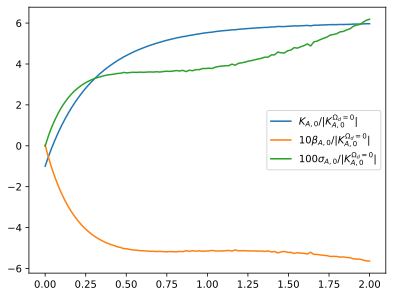

In [107]:
r3_squared_list = np.linspace(0, 2.0, 100)
cavity_nonlinearities = []

for idx, r3_squared in enumerate(r3_squared_list):

    r3_norm = np.sqrt(r3_squared)
    self_Kerr, beta_Kerr, sigma_Kerr = comp_self_Kerr(r3_val=r3_norm, dim_a_val=15, dim_c_val=5)
    
    if idx == 0:
        abs_self_Kerr_no_drive = np.abs(self_Kerr)
    
    self_Kerr_norm = self_Kerr/abs_self_Kerr_no_drive
    beta_Kerr_norm = 10*beta_Kerr/abs_self_Kerr_no_drive
    sigma_Kerr_norm = 100*sigma_Kerr/abs_self_Kerr_no_drive
 
    cavity_nonlinearities.append([self_Kerr_norm, beta_Kerr_norm, sigma_Kerr_norm])
    
cavity_nonlinearities = np.array(cavity_nonlinearities)

plt.plot(r3_squared_list, cavity_nonlinearities[:, 0], label=r'$K_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.plot(r3_squared_list, cavity_nonlinearities[:, 1], label=r'$10\beta_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.plot(r3_squared_list, cavity_nonlinearities[:, 2], label=r'$100\sigma_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.legend()

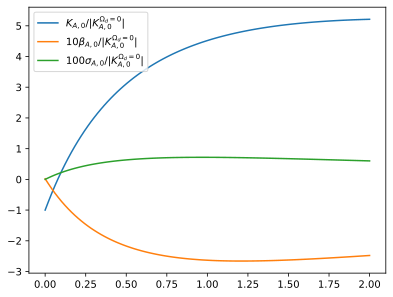

In [108]:
r3_squared_list = np.linspace(0, 2.0, 100)
cavity_nonlinearities = []

for idx, r3_squared in enumerate(r3_squared_list):

    r3_norm = np.sqrt(r3_squared)
    self_Kerr, beta_Kerr, sigma_Kerr = comp_self_Kerr(r3_val=r3_norm, dim_a_val=50, dim_c_val=25)
    
    if idx == 0:
        abs_self_Kerr_no_drive = np.abs(self_Kerr)
    
    self_Kerr_norm = self_Kerr/abs_self_Kerr_no_drive
    beta_Kerr_norm = 10*beta_Kerr/abs_self_Kerr_no_drive
    sigma_Kerr_norm = 100*sigma_Kerr/abs_self_Kerr_no_drive
 
    cavity_nonlinearities.append([self_Kerr_norm, beta_Kerr_norm, sigma_Kerr_norm])
    
cavity_nonlinearities = np.array(cavity_nonlinearities)

plt.plot(r3_squared_list, cavity_nonlinearities[:, 0], label=r'$K_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.plot(r3_squared_list, cavity_nonlinearities[:, 1], label=r'$10\beta_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.plot(r3_squared_list, cavity_nonlinearities[:, 2], label=r'$100\sigma_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.legend()

In [109]:
r3_squared_list = np.linspace(0, 2.0, 200)
cavity_nonlinearities = []

for idx, r3_squared in enumerate(r3_squared_list):

    r3_norm = np.sqrt(r3_squared)
    self_Kerr, beta_Kerr, sigma_Kerr = comp_self_Kerr(r3_val=r3_norm, dim_a_val=100, dim_c_val=70)
    
    if idx == 0:
        abs_self_Kerr_no_drive = np.abs(self_Kerr)
    
    self_Kerr_norm = self_Kerr/abs_self_Kerr_no_drive
    beta_Kerr_norm = 10*beta_Kerr/abs_self_Kerr_no_drive
    sigma_Kerr_norm = 100*sigma_Kerr/abs_self_Kerr_no_drive
 
    cavity_nonlinearities.append([self_Kerr_norm, beta_Kerr_norm, sigma_Kerr_norm])
    
cavity_nonlinearities = np.array(cavity_nonlinearities)

plt.plot(r3_squared_list, cavity_nonlinearities[:, 0], label=r'$K_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.plot(r3_squared_list, cavity_nonlinearities[:, 1], label=r'$10\beta_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.plot(r3_squared_list, cavity_nonlinearities[:, 2], label=r'$100\sigma_{A,0}/|K_{A,0}^{\Omega_d=0}|$')
plt.legend()

KeyboardInterrupt: 